In [2]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from pathlib import Path
from IPython.core.debugger import set_trace
import scipy.io
import re
import os
from collections import defaultdict
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib.pyplot as plt

In [21]:
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [20]:
IPython_default = plt.rcParams.copy()

In [75]:
def receptive_field(kernel_num, stack, dilation):
    
    kernel_size = kernel_num
    nb_stacks = stack
    #dilat = [*range(1, dilation, 1)]
    dilations = [2 ** i for i in range(dilation)]
    return 1 + 2 * (kernel_size - 1) * nb_stacks * sum(dilations)

def split_nums(string_in):
    numbs = re.findall(r"[-+]?\d*\.\d+|\d+", string_in)
    return numbs

def Read_plot_func(model_ids):
    
    step_path = Path("./")
    training_path = step_path / 'training_results_by_acc.csv'
    epoch_path = step_path / 'epoch_results.csv'
    #step_path = FILE_NAMES / 'Step_results'
    path_100 = step_path / 'List_Check_100.csv'
    path_200 = step_path / 'List_Check_200.csv'
    path_300 = step_path / 'List_Check_300.csv'
    path_400 = step_path / 'List_Check_400.csv'
    path_500 = step_path / 'List_Check_500.csv'
    step_arr = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
    drop_arr = ['C1 correct', 'C1 as C2', 'C1 as C3', 'C1 as C4', 'C2 as C1', 'C2 correct', 'C2 as C3', 'C2 as C4', 'C3 as C1', 'C3 as C2', 'C3 correct', 'C3 as C4', 'C4 as C1', 'C4 as C2', 'C4 as C3', 'C4 correct']
    train_results = pd.read_csv(training_path, index_col=0)
    epoch_results = pd.read_csv(epoch_path, index_col=1)
    results_100 = pd.read_csv(path_100)
    step_arr_100 = step_arr*1
    results_100.insert(1, 'Step Length', step_arr_100)
    results_100.drop(drop_arr, axis=1, inplace=True)
    results_200 = pd.read_csv(path_200)
    step_arr_200 = step_arr*2
    results_200.insert(1, 'Step Length', step_arr_200)
    results_200.drop(drop_arr, axis=1, inplace=True)
    results_300 = pd.read_csv(path_300)
    step_arr_300_1 = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
    step_arr_300 = step_arr_300_1*3
    results_300.insert(1, 'Step Length', step_arr_300)
    results_300.drop(drop_arr, axis=1, inplace=True)
    results_400 = pd.read_csv(path_400)
    step_arr_400 = step_arr*4
    results_400.insert(1, 'Step Length', step_arr_400)
    results_400.drop(drop_arr, axis=1, inplace=True)
    results_500 = pd.read_csv(path_500)
    step_arr_500 = step_arr*5
    results_500.insert(1, 'Step Length', step_arr_500)
    results_500.drop(drop_arr, axis=1, inplace=True)
    
    ids_all = train_results.index
    all_ids = pd.Series(pd.unique(ids_all))
    
    
    combined_results = results_100
    combined_results = combined_results.append(results_200)
    combined_results = combined_results.append(results_300)
    combined_results = combined_results.append(results_400)
    combined_results = combined_results.append(results_500).reset_index(drop=True)
    

    
    
    
    Epoch_times = defaultdict()
    train_loss = defaultdict()
    train_acc = defaultdict()
    eval_loss = defaultdict()
    eval_acc = defaultdict()
    params = defaultdict()
    field = defaultdict()
    
    style_dict = {'k6D7s2f32_2400_100':'--',
              'k6D7s2f32_2400_300':'--',
              'k11D7s1f16_2400_300':'c-',
              'k8D8s1f64_3600_100':'--',
              'k6D8s1f64_2400_300':'--',
              'k8D8s1f16_3600_300':'--',
              'k11D7s1f16_2400_200':'--',
              'k16D6s2f32_3600_200':'--',
              'k11D7s1f32_2400_300':'--',
              'k6D7s2f32_2400_200':'--'}
    lw_dict = [0.5,0.5,2,0.5,0.5,0.5,0.5,0.5,0.5,0.5]
    

    
    
    print(model_ids)
    #Per epoch training data
    for ids in model_ids:
        splits = split_nums(ids)
        params['%s' % ids] = [{'k': [int(splits[0])], 'D': int(splits[1]), 'st': int(splits[2]), 'f': int(splits[3]), 'seg len': int(splits[4]), 'step':int(splits[5])}]
        print(params[ids])
        specific_model = epoch_results.loc[ids]
        Epoch_times['%s' % ids] = specific_model.iloc[0, :]
        train_loss['%s' % ids] = specific_model.iloc[1, :]
        train_acc['%s' % ids] = specific_model.iloc[2, :]
        eval_loss['%s' % ids] = specific_model.iloc[3, :]
        eval_acc['%s' % ids] = specific_model.iloc[4, :]
        
        

    #for ids in all_ids:
        
    field_arr = []
    Acc_arr = []
    for index, row in combined_results.iterrows():

        #print(row)
        rec_field = receptive_field(int(row["kernel size"]), int(row["stacks"]), int(row["dilation"]))
        field_arr.append(rec_field)
        Acc_arr.append(row["Eval Acc"])

    #Field_df = pd.DataFrame([field_ser, Acc_ser], index = ['Field', 'Acc']).T
           
    Epoch_timedf = df.from_dict(Epoch_times)
    train_lossdf= df.from_dict(train_loss)
    train_accdf= df.from_dict(train_acc)
    eval_lossdf= df.from_dict(eval_loss)
    eval_accdf= df.from_dict(eval_acc)
    #field_df = df.from_dict(field)
    train_accdf = train_accdf[1:].applymap(lambda x: x*100)
    eval_accdf = eval_accdf[1:].applymap(lambda x: x*100)
    

    with plt.style.context('ggplot'):
        plt.figure();
        #Epoch_timedf[1:].plot(legend=True, title='Epoch Time')
        Epoch_timedf[1:34].plot(legend=True, title='Epoch Time', xlabel="Epoch", ylabel="Time per Epoch",lw=1).legend(bbox_to_anchor=(1,1))

        plt.figure();
        #train_lossdf[2:].plot(legend=True, title=' Training Loss')
        train_lossdf[1:34].plot(legend=True, title=' Training Loss', xlabel="Epoch", ylabel="Loss", style=style_dict,lw=1).legend(bbox_to_anchor=(1,1))
        train_lossdf[10:34].plot(legend=True, title=' Training Loss', xlabel="Epoch", ylabel="Loss", logy=False, style=style_dict,lw=1).legend(bbox_to_anchor=(1,1))
        #plt.figure();
        #train_lossdfs[2:].plot(legend=None )#ylim=[0,1])

        plt.figure();
        #train_accdf[3:].plot(legend=True, title='Training Acc') #, logy=True)
        train_accdf[1:34].plot(legend=True, title='Training Acc', xlabel="Epoch", ylabel="Accuracy (Percentage)", style=style_dict,lw=1).legend(bbox_to_anchor=(1,1)) #, logy=True)
        train_accdf[10:34].plot(legend=True, title='Training Acc', xlabel="Epoch", ylabel="Accuracy (Percentage)", logy=False, style=style_dict,lw=1).legend(bbox_to_anchor=(1,1))
        #plt.figure();
        #train_accdfs[3:].plot(legend=None, logy=True)

        plt.figure();
        #eval_lossdf[2:].plot(legend=True, title='Eval Loss') #, logy=True)
        eval_lossdf[1:34].plot(legend=True, title='Eval Loss', xlabel="Epoch", ylabel="Loss", style=style_dict,lw=1).legend(bbox_to_anchor=(1,1))
        eval_lossdf[10:34].plot(legend=True, title='Eval Loss', xlabel="Epoch", ylabel="Loss", logy=False, style=style_dict,lw=1).legend(bbox_to_anchor=(1,1))
        #plt.figure();
        #eval_lossdfs[2:].plot(legend=None, logy=False)


        plt.figure();
        #eval_accdf[2:].plot(legend=True, title='Eval Acc') #, logy=True) #, xlim=[0, 55], ylim=[35,100])
        eval_accdf[1:34].plot(legend=True, title='Evaluation Accuracy', xlabel="Epoch", ylabel="Accuracy (Percentage)", style=style_dict,lw=1).legend(bbox_to_anchor=(1,1)) #, xlim=[0, 55], ylim=[35,100])
        eval_accdf[10:34].plot(legend=True, title='Evaluation Accuracy', xlabel="Epoch", ylabel="Accuracy (Percentage)", logy=False, style=style_dict,lw=1).legend(bbox_to_anchor=(1,1))
        
        

        #plt.figure();
        #combined_results.plot.bar(x="kernel size", y="Eval Acc", title='Kernal Size vs Prediction Accuracy')
        #Field_df.plot.scatter(x="Field", y="Acc", title='Receptive Field vs Prediction Accuracy')

    return results_100, results_200, results_300, results_400, results_500, combined_results, Epoch_timedf, train_lossdf, train_accdf, eval_lossdf, eval_accdf

In [62]:
style_dict = {'k6D7s2f32_2400_100':'--',
              'k6D7s2f32_2400_300':'--',
              'k11D7s1f16_2400_300':'-',
              'k8D8s1f64_3600_100':'--',
              'k6D8s1f64_2400_300':'--',
              'k8D8s1f16_3600_300':'--',
              'k11D7s1f16_2400_200':'--',
              'k16D6s2f32_3600_200':'--',
              'k11D7s1f32_2400_300':'--',
              'k6D7s2f32_2400_200':'--'}
lw_dict = [0.5,0.5,2,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

In [3]:
import matplotlib.pyplot as plt
plt.close("all")

In [13]:
step_path = Path("./")
training_path = step_path / 'training_results_by_acc.csv'
epoch_path = step_path / 'epoch_results.csv'
#step_path = FILE_NAMES / 'Step_results'
path_100 = step_path / 'List_Check_100.csv'
path_200 = step_path / 'List_Check_200.csv'
path_300 = step_path / 'List_Check_300.csv'
path_400 = step_path / 'List_Check_400.csv'
path_500 = step_path / 'List_Check_500.csv'

In [14]:
train_results = pd.read_csv(training_path, index_col=0)
epoch_results = pd.read_csv(epoch_path, index_col=1)
results_100 = pd.read_csv(path_100)
results_200 = pd.read_csv(path_200)
results_300 = pd.read_csv(path_300)
results_400 = pd.read_csv(path_400)
results_500 = pd.read_csv(path_500)

In [10]:
train_results_t20 = train_results[:20]
train_results_t10 = train_results[:10]
train_results_t5 = train_results[:5]
t20 = train_results_t20.index
model_id_t20 = pd.Series(pd.unique(t20))
t10 = train_results_t10.index
model_id_t10 = pd.Series(pd.unique(t10))
t5 = train_results_t5.index
model_id_t5 = pd.Series(pd.unique(t5))


0     k6D7s2f32_2400_100
1     k6D7s2f32_2400_300
2    k11D7s1f16_2400_300
3     k8D8s1f64_3600_100
4     k6D8s1f64_2400_300
5     k8D8s1f16_3600_300
6    k11D7s1f16_2400_200
7    k16D6s2f32_3600_200
8    k11D7s1f32_2400_300
9     k6D7s2f32_2400_200
dtype: object
[{'k': [6], 'D': 7, 'st': 2, 'f': 32, 'seg len': 2400, 'step': 100}]
[{'k': [6], 'D': 7, 'st': 2, 'f': 32, 'seg len': 2400, 'step': 300}]
[{'k': [11], 'D': 7, 'st': 1, 'f': 16, 'seg len': 2400, 'step': 300}]
[{'k': [8], 'D': 8, 'st': 1, 'f': 64, 'seg len': 3600, 'step': 100}]
[{'k': [6], 'D': 8, 'st': 1, 'f': 64, 'seg len': 2400, 'step': 300}]
[{'k': [8], 'D': 8, 'st': 1, 'f': 16, 'seg len': 3600, 'step': 300}]
[{'k': [11], 'D': 7, 'st': 1, 'f': 16, 'seg len': 2400, 'step': 200}]
[{'k': [16], 'D': 6, 'st': 2, 'f': 32, 'seg len': 3600, 'step': 200}]
[{'k': [11], 'D': 7, 'st': 1, 'f': 32, 'seg len': 2400, 'step': 300}]
[{'k': [6], 'D': 7, 'st': 2, 'f': 32, 'seg len': 2400, 'step': 200}]


<Figure size 640x480 with 0 Axes>

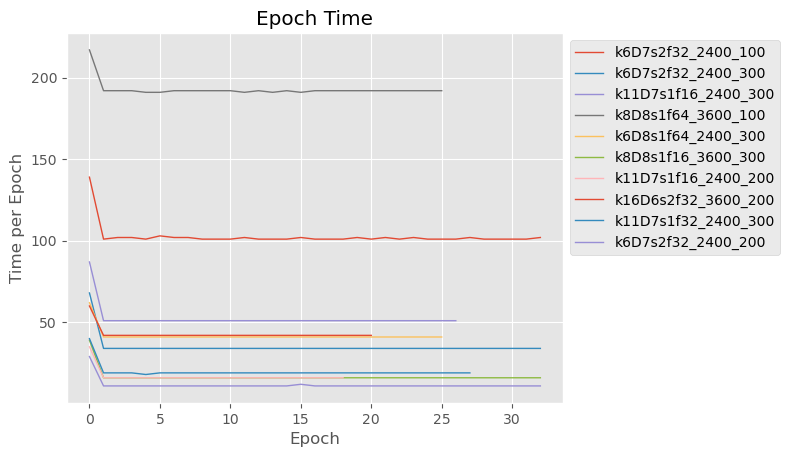

<Figure size 640x480 with 0 Axes>

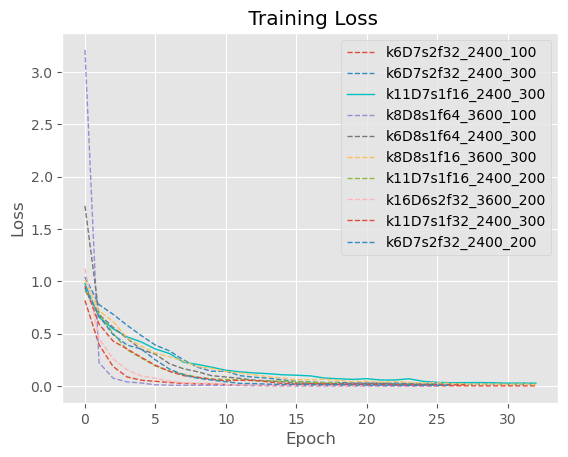

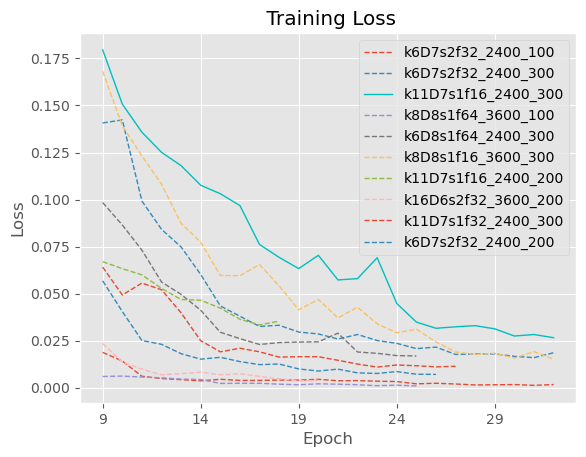

<Figure size 640x480 with 0 Axes>

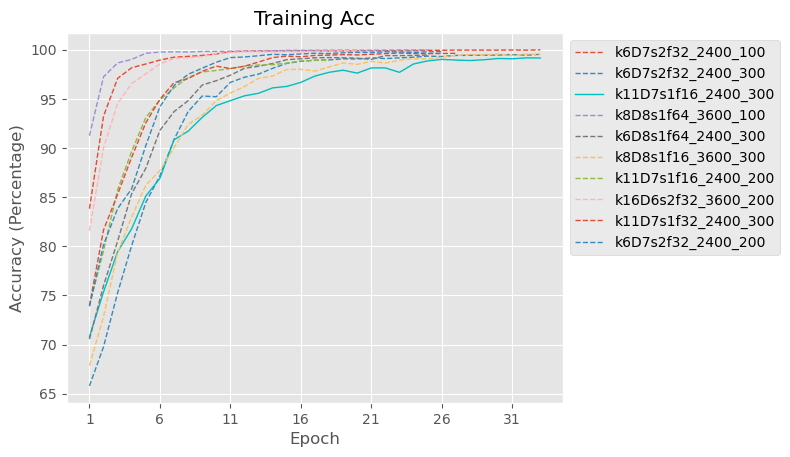

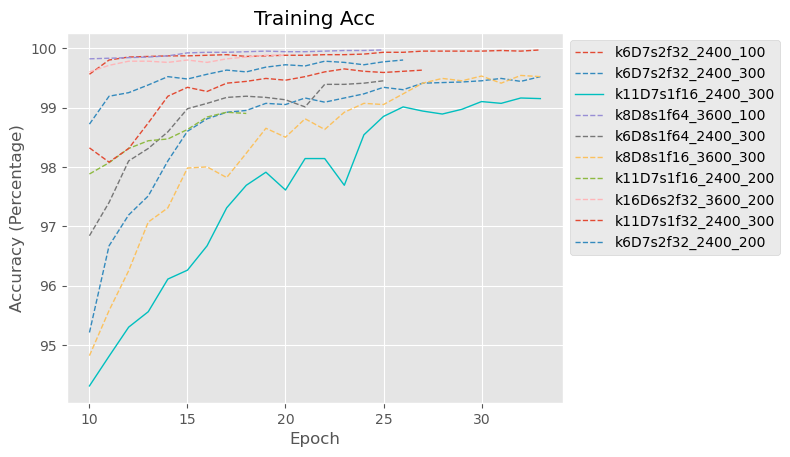

<Figure size 640x480 with 0 Axes>

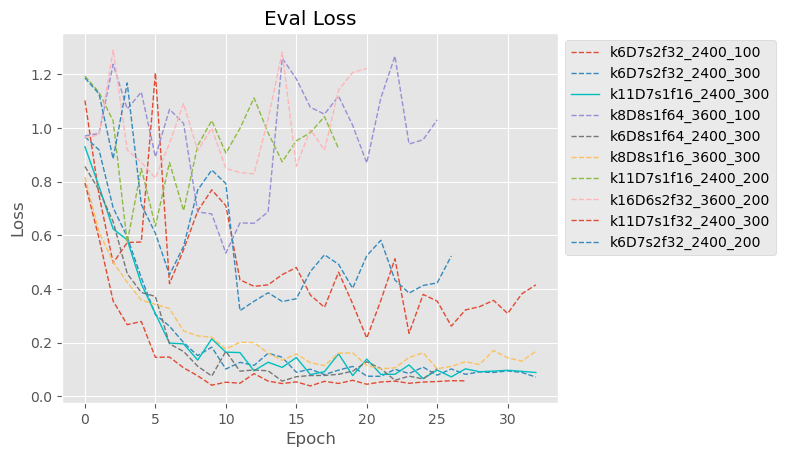

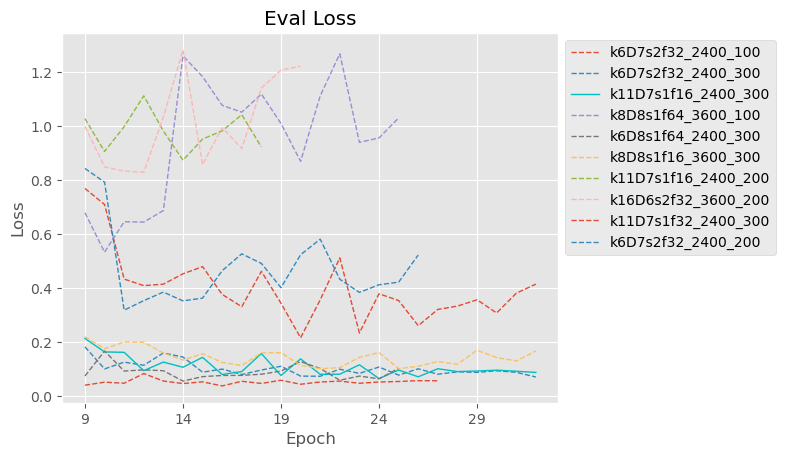

<Figure size 640x480 with 0 Axes>

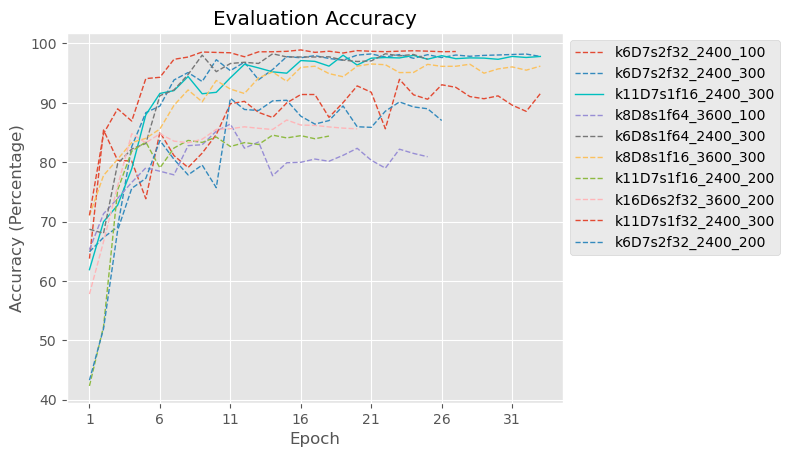

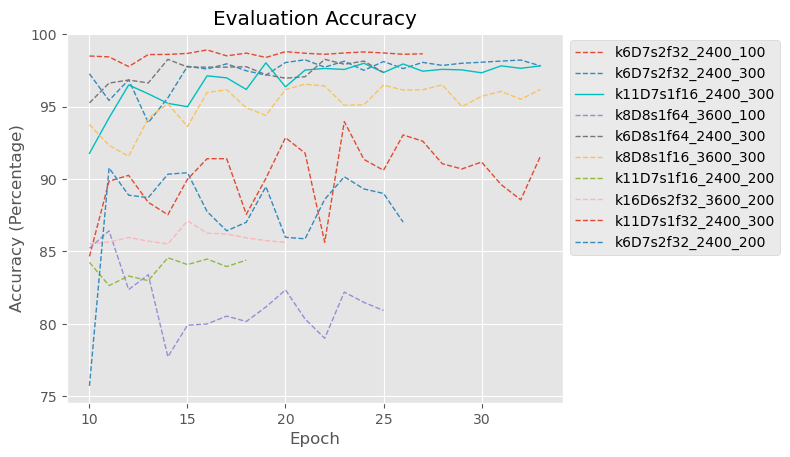

In [76]:
results_100, results_200, results_300, results_400, results_500, combined_results, epoch_timedf, train_lossdf, train_accdf, eval_lossdf, eval_accdf = Read_plot_func(model_id_t10)

In [ ]:
[{'k': [int(splits[0])], 'D': int(splits[1]), 'st': int(splits[2]), 'f': int(splits[3]), 'seg len': int(splits[4]), 'step':int(splits[5])}]

In [31]:
combined_results = results_100
combined_results = combined_results.append(results_200)
combined_results = combined_results.append(results_300)
combined_results = combined_results.append(results_400)
combined_results = combined_results.append(results_500).reset_index(drop=True)

In [158]:
combined_results.columns

Index(['segment length', 'Step Length', 'filters', 'kernel size', 'stacks',
       'dropout', 'lr', 'dilation', 'Training Time', 'train loss', 'train acc',
       'eval acc', 'Eval Acc'],
      dtype='object')

In [160]:
#append_list_time1.sort_values(by='Eval Acc', ascending=False)
combined_results.sort_values(by='Eval Acc', ascending=False).to_csv(r'{}.csv'.format('Combined_Results'), index = False, header=['segment length', 'Step Length', 'filters', 'kernel size', 'stacks','dropout', 'lr', 'dilation', 'Training Time', 'train loss', 'train acc','eval acc', 'Eval Acc'])

In [ ]:
train_accdf = train_accdf[1:].applymap(lambda x: x*100)
eval_accdf = eval_accdf[1:].applymap(lambda x: x*100)